Compartmental models in NEST:
==========================

**[Joshua Böttcher](mailto:j.boettcher@fz-juelich.de), [Willem Wybo](mailto:w.wybo@fz-juelich.de)**


# Introduction

Compartmental models are systems of coupled ODEs, used to model spatially extended neurons. Mathematically, a compartment is described by the ODE
\begin{align}\label{eq:comp}
c_i \dot{v}_i(t) = g_{L,i} \, (e_{L,i} - v_i(t)) + \sum_{n \in {neighbours}} g_{C,in} \, (v_{n}(t) - v_i(t)) + \text{channel currents} + \text{synapse currents}, 
\end{align}
with $c_i$ the capacitance of the compartment, $g_{L,i}$ resp. $e_{L,i}$ its leak conductance resp. reversal and $g_{C,in}$ its coupling conductance to the neighbouring compartment $n$. A morphological model consists of a number of compartments, coupled to each other as a tree graph. The structure of the tree thus determines the coupling between compartments: only compartments that share an edge have a non-zero coupling conductance between them. Compartments can further be equipped with ion channels and synaptic input currents.

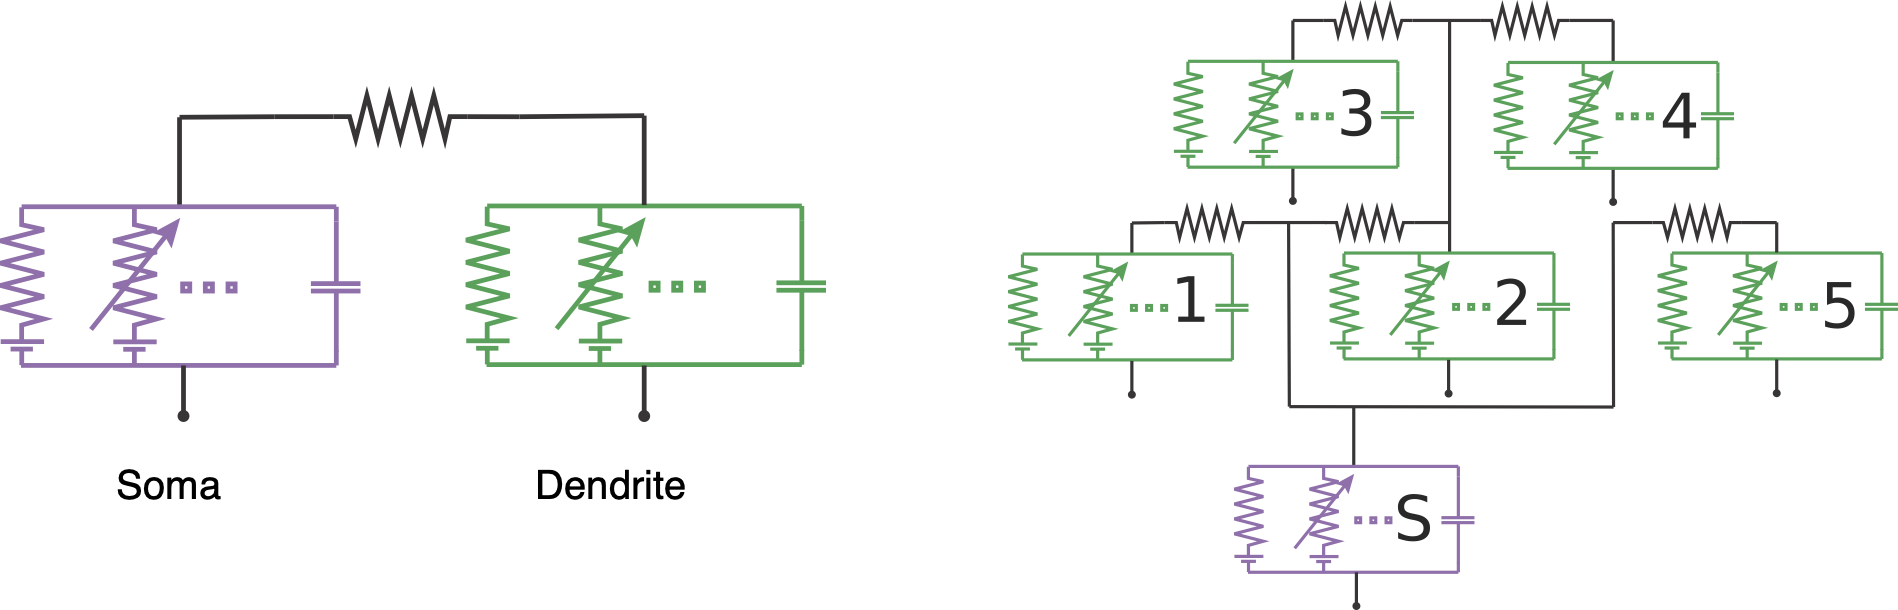

Compartmental models are supported in NEST through the nest model [`'cm_default'`](https://nest-simulator.readthedocs.io/en/v3.3/models/cm_default.html). This model implements default sodium and potassium channels and four synaptic receptor types. The compartmental model architecture further supports configurable compartmental layouts, defined by the user at runtime. While most simulators (NEURON, Arbor) have chosen a high-level API, where morphologies are loaded from data files and converted internally to systems of compartmental ODEs, NEST, with its focus on simplified neuron models, has chosen a low-level interface, where compartments are added explicitely. In this tutorial, we will define a neuron model by explicitly adding compartments, and we will simulate this neuron model to produce a number of dendritic computations.

## Complementary tools

#### NESTML

The default compartmental model can be customized through [NESTML](https://nestml.readthedocs.io/en/latest/). Custom ion channels and receptor currents can be defined in NESTML, and will be translated into their own custom compartmental model. In another tutorial, we will describe how such models can be defined and compiled. Interaction with such models is identical to the default compartmental model described here, except that the default ion channel parameter fields and state variable fields will be replaced with the ones define in the NESTML model.

#### NEAT

While the low-level API to compartmental models in NEST is great for exploring how specific parameters influence the interaction between compartments, a number of use cases requires a high-level API, especially in data-driven modelling. The NEural Analysis Toolbox ([NEAT](https://neatdend.readthedocs.io/en/latest/)) implements the possibility to load morphologies from data files and to specify physiological parameters through high-level function (e.g. for the whole neuron). It also implements a number of algorithms to analyze neuronal morphologies, notably to simplify them into models with few compartments. An automatic pipeline to export models to NEST is under construction. In the meantime, simplified model parameters can already be extracted from NEAT trees and directly transferred to NEST through user-defined code using the NEST API.

# 1) Model specification
To start configuring a compartmental model, we import `nest` and create an empty model.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import nest
cm = nest.Create("cm_default")

Note that contrarily to other model types, the model `cm` is actually empty. It has no compartments. Trying to connect anything to it will give an error.

In [2]:
try:
    sg = nest.Create('spike_generator', 1)
    nest.Connect(sg, cm)
except Exception as e:
    print(e)

UnknownPort in SLI function Connect_g_g_D_D: Port with id 0 does not exist. Valid spike receptor ports for cm_default are in [0, 0[.


### 1.1) Defining the compartment parameters 

In order to use the model `cm`  we need to define the parameters of our compartments. Note that the parameters defined below are extracted using NEAT, to represent a Layer 5 Pyramidal cell's soma, and a distal dendritic compartment on the basal dendrites.

In [3]:
soma_params = {
    # passive parameters
    'C_m':  0.330880516,        # [nF] Capacitance
    'g_C': 0.0,                 # soma has no parent
    'g_L':  0.015135876677,     # [uS] Leak conductance
    'e_L': -75.00046388760929,  # [mV] leak reversal
    # ion channel params
    'gbar_Na': 22.036637488000, # [nS] Na maximal conductance
    'e_Na': 50.,                # [mV] Na reversal
    'gbar_K': 9.871382640833,   # [nS] K maximal conductance
    'e_K': -85.                 # [mV] K reversal
}
dend_params = {
    # passive parameters
    'C_m': 0.002124942,         # [nF] Capacitance
    'g_C': 0.000552611865,      # [uS] Coupling with parent
    'g_L': 0.000072191148,      # [uS] Leak conductance
    'e_L': -75.0,               # [mV] Leak reversal
}

We will then create compartments for our model:

In [4]:
cm.compartments = [
    {"parent_idx": -1, "params": soma_params},
    {"parent_idx":  0, "params": dend_params},
    {"parent_idx":  0, "params": dend_params},
    {"parent_idx":  0, "params": dend_params},
    {"parent_idx":  0, "params": dend_params},
    {"parent_idx":  0, "params": dend_params},
]

In this case, we have created a somatic compartment and five dendritic compartments, each connected to the soma. This corresponds to a simplified dendritic configuration with five branches. Compartments are assigned indices in the order in which they figure in the provided list, with this constraint that the somatic compartment always has to be added first. By consequence, the somatic compartment has index 0, and dendritic compartments have indices 1 to 5. Thus, specifying `"parent_idx": 0` means that these dendritic compartments have the soma as parent in the tree graph, resulting in the following layout:

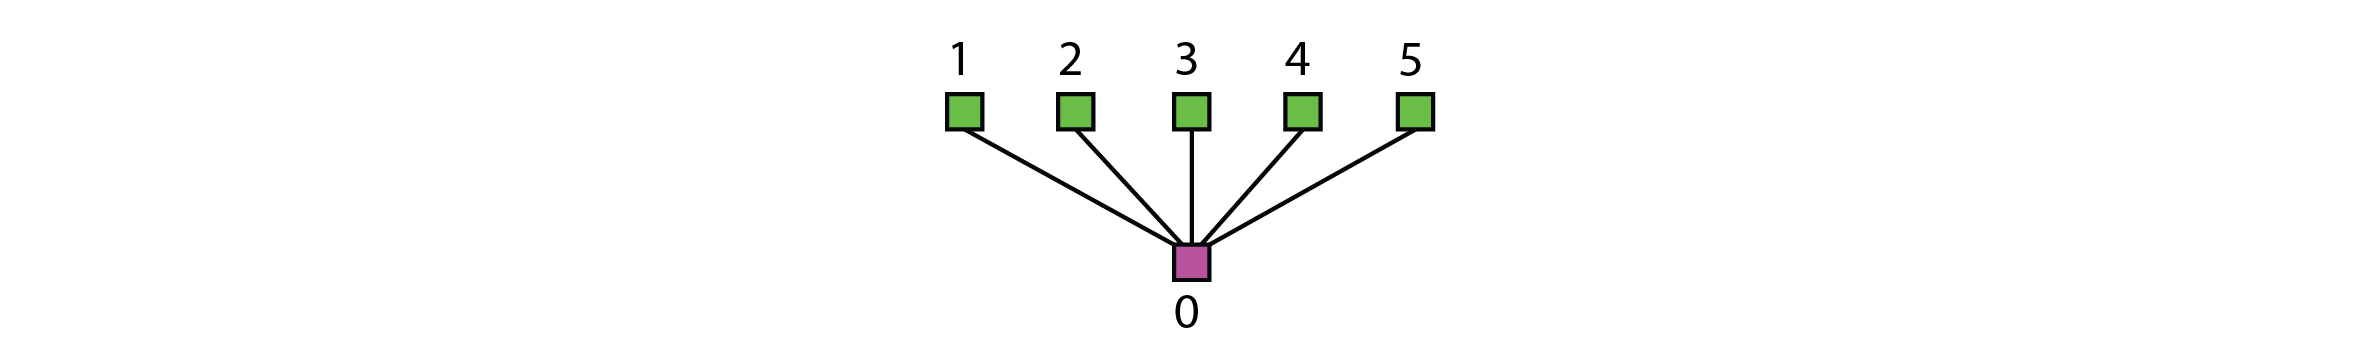

Note that the coupling conductance between compartments $i$ and $j$ is always symmetric (i.e. $g_{C,ij} = g_{C,ji}$). Thus, we only define the coupling between two compartments once, when a given compartment is added (parameter `'g_C'`), and it is understood that this is the coupling between the current compartment and its parent.

Further, we remark that care should be taken that the `"parent_idx"` for a given compartment is already in the tree when the compartment is added. Since compartments are added in the order in which they appear in the list, valid parent indices should always be smaller than the index of current entry. For example, the following code will give an error:

In [5]:
cm_test = nest.Create("cm_default")
try:
    cm_test.compartments = [
        {"parent_idx": 0},
        {"parent_idx": -1}
    ]
except Exception as e:
    print(e)
    
nest.ResetKernel()

UnknownCompartment in SLI function SetStatus_id: Compartment 0 does not exist in tree, but was specified as a parent compartment.


Finally, we note that not specifying parameters in the `"params"` entry results in the [default parameters values](https://nest-simulator.readthedocs.io/en/v3.3/models/cm_default.html) being used in the compartment. As the default conductances are 0 for the ion channels, the following defines a passive model:

In [6]:
soma_params_pas = {key: val for key, val in soma_params.items() if key in ["C_m", "g_C", "g_L", "e_L"]}

cm_pas = nest.Create('cm_default')
cm_pas.compartments = [
    {"parent_idx": -1, "params": soma_params_pas},
    {"parent_idx":  0, "params": dend_params},
    {"parent_idx":  0, "params": dend_params},
    {"parent_idx":  0, "params": dend_params},
    {"parent_idx":  0, "params": dend_params},
    {"parent_idx":  0, "params": dend_params},
]

### 1.2) Connecting synaptic inputs

Now, we will connect synaptic inputs to the compartments. To do so, we must equip compartments with receptors. A receptor is assigned to a given compartment, which is specified by its index (`"comp_idx"` entry), which in turn corresponds to the order in which the compartments were added. In the following, we will add a single an AMPA receptor to each dendritic compartment, and an AMPA+NMDA receptor:

In [7]:
cm_pas.receptors = [
    # AMPA receptors to all dendritic compartments
    {"comp_idx": 1, "receptor_type": "AMPA"},
    {"comp_idx": 2, "receptor_type": "AMPA"},
    {"comp_idx": 3, "receptor_type": "AMPA"},
    {"comp_idx": 4, "receptor_type": "AMPA"},
    {"comp_idx": 5, "receptor_type": "AMPA"},
    # AMPA+NMDA receptors to all dendritic compartments
    {"comp_idx": 1, "receptor_type": "AMPA_NMDA"},
    {"comp_idx": 2, "receptor_type": "AMPA_NMDA"},
    {"comp_idx": 3, "receptor_type": "AMPA_NMDA"},
    {"comp_idx": 4, "receptor_type": "AMPA_NMDA"},
    {"comp_idx": 5, "receptor_type": "AMPA_NMDA"},
]

Receptors are assigned indices in the same way as compartments: based on the order in which they are added. Thus, a receptor index corresponds to its position in the list. In this case, the `"AMPA"` receptors have receptor indices 0 to 4, and the `"AMPA_NMDA"` receptors indices 5 to 9. If receptors parameters that differ from the default values are needed, they can be specified by adding a `"params"` entry to the status dictionary. E.g. to change the NMDA-ratio of receptor 5 from the default of 1 to 2, we would replace
```
    {"comp_idx": 1, "receptor_type": "AMPA_NMDA"},
```
with
```
    {"comp_idx": 1, "receptor_type": "AMPA_NMDA", "params": {'NMDA_ratio': 2.}},
```

$ \\ $

Now, we have fully specified the compartmental model and are ready to connect an input to it. We create a spike generator and connect it receptor 0. We must specify the receptor index under the `"receptor_type"` entry of the `syn_spec` dictionary:

In [8]:
sg = nest.Create('spike_generator', 1, {'spike_times': [5.]})
nest.Connect(
    sg, cm_pas, 
    syn_spec={
        'synapse_model': 'static_synapse', 
        'weight': .001, # uS
        'delay': 0.5, 
        'receptor_type': 0,
    }
)

### 1.3) Recording

To record state variables of the model, we suffix the state variable name either with the compartment index -- if the state variable is the voltage or associated to an ion channel -- or the receptor index -- if the state variable is associated with a receptor. Thus, in the `record_from` attribute of a multimeter, we specify
```
"{state_variable_name}{compartment_index}"
```
for the compartmental voltage or ion channel state variables, and
```
"{state_variable_name}{receptor_index}"
```
for the receptor state variables.

Valid state variable names in the default model are:

|**Voltage** | **ion channels**|      | **receptors** |           |           |              |
|------------|-----------------|------|---------------|-----------|-----------|--------------|
|            | *Na*            |*K*   | *AMPA*        | *GABA*    | *NMDA*    | *AMPA_NMDA*  |
|v_comp      |m_Na_            |n_K_  | g_r_AMPA_     | g_r_GABA_ | g_r_NMDA_ | g_r_AN_AMPA_ |
|            |h_Na_            |      | g_d_AMPA_     | g_d_GABA_ | g_d_NMDA_ | g_d_AN_AMPA_ |
|            |                 |      |               |           |           | g_r_AN_NMDA_ |
|            |                 |      |               |           |           | g_d_AN_NMDA_ |


With the following multimeter, we record all voltages

In [9]:
mm = nest.Create('multimeter', 1)
mm.record_from = [
    'v_comp0', 'v_comp1', 'v_comp2', 'v_comp3', 'v_comp4', 'v_comp5'
]
nest.Connect(mm, cm_pas)

Let's now run this simulation and plot the results

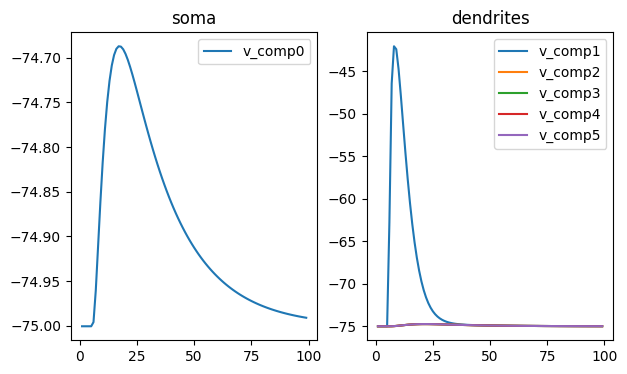

In [10]:
nest.Simulate(100.)
res = nest.GetStatus(mm, 'events')[0]

plt.figure(figsize=(7,4))

ax1 = plt.subplot(121)
ax1.set_title("soma")
plt.plot(res['times'], res['v_comp0'], label='v_comp0')
plt.legend(loc=0)

ax2 = plt.subplot(122)
ax2.set_title("dendrites")
plt.plot(res['times'], res['v_comp1'], label='v_comp1')
plt.plot(res['times'], res['v_comp2'], label='v_comp2')
plt.plot(res['times'], res['v_comp3'], label='v_comp3')
plt.plot(res['times'], res['v_comp4'], label='v_comp4')
plt.plot(res['times'], res['v_comp5'], label='v_comp5')
plt.legend(loc=0)

plt.show()

We can see that with the compartment parameters chosen here, the dendritic compartment is very well isolated from the somatic compartment and the other dendrites. Only a small part of the dendritic depolarization arrives at the soma and other dendritic compartments.

Before proceeding, let us capture some neuron creation routines in convenient functions

In [11]:
def create_neuron_w_dend_receptors(passive_soma=False, AMPA_params={}, AMPA_NMDA_params={}):
    if passive_soma:
        soma_params_ = soma_params_pas
    else:
        soma_params_ = soma_params
    
    # define the model with its compartments
    cm = nest.Create('cm_default')
    cm.compartments = [
        {"parent_idx": -1, "params": soma_params_},
        {"parent_idx":  0, "params": dend_params},
        {"parent_idx":  0, "params": dend_params},
        {"parent_idx":  0, "params": dend_params},
        {"parent_idx":  0, "params": dend_params},
        {"parent_idx":  0, "params": dend_params},
    ]
    # add the dendritic receptors
    cm.receptors = [
        # AMPA receptors to all dendritic compartments
        {"comp_idx": 1, "receptor_type": "AMPA", "params": AMPA_params},
        {"comp_idx": 2, "receptor_type": "AMPA", "params": AMPA_params},
        {"comp_idx": 3, "receptor_type": "AMPA", "params": AMPA_params},
        {"comp_idx": 4, "receptor_type": "AMPA", "params": AMPA_params},
        {"comp_idx": 5, "receptor_type": "AMPA", "params": AMPA_params},
        # AMPA+NMDA receptors to all dendritic compartments
        {"comp_idx": 1, "receptor_type": "AMPA_NMDA", "params": AMPA_NMDA_params},
        {"comp_idx": 2, "receptor_type": "AMPA_NMDA", "params": AMPA_NMDA_params},
        {"comp_idx": 3, "receptor_type": "AMPA_NMDA", "params": AMPA_NMDA_params},
        {"comp_idx": 4, "receptor_type": "AMPA_NMDA", "params": AMPA_NMDA_params},
        {"comp_idx": 5, "receptor_type": "AMPA_NMDA", "params": AMPA_NMDA_params},
    ]
    
    return cm

def plot_dend_and_soma(res):
    plt.figure(figsize=(7,4))

    ax1 = plt.subplot(121)
    ax1.set_title("soma")
    plt.plot(res['times'], res['v_comp0'], label='v_comp0')
    plt.legend(loc=0)

    ax2 = plt.subplot(122)
    ax2.set_title("dendrites")
    plt.plot(res['times'], res['v_comp1'], label='v_comp1')
    plt.plot(res['times'], res['v_comp2'], label='v_comp2')
    plt.plot(res['times'], res['v_comp3'], label='v_comp3')
    plt.plot(res['times'], res['v_comp4'], label='v_comp4')
    plt.plot(res['times'], res['v_comp5'], label='v_comp5')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.show()

$\ \$

# 2) Dendritic computation

## 2.1) Sublinear summation

Now that the basics are understood, let's try to see if we can implement dendritic computations. First, we'll compare summation of inputs at the AMPA synapses. A single PSP induced a max depolarization of 

In [12]:
delta_v = np.max(res['v_comp0']) - res['v_comp0'][0]
print(f"{delta_v:.5f} mV")

0.31301 mV


### 2.1.1) Distributed input
What is the maximum somatic depolarization if all dendritic AMPA receptors are activated at the same time? 

**TODO:** To model this distributed input scenario, connect a spike generator to the AMPA receptors and then simulate the model.

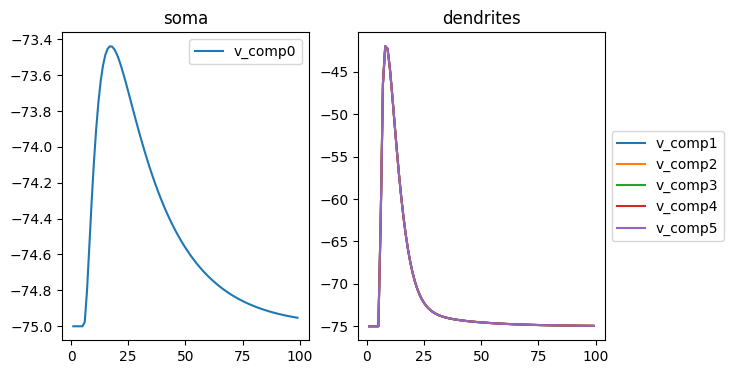

For distributed input, we obtain a somatic depolarization of 1.56126 mV, very close to the linear sum of 1.56507 mV


In [13]:
nest.ResetKernel()

cm = create_neuron_w_dend_receptors(passive_soma=True)

# create and connect the spike generator
sg = nest.Create('spike_generator', 1, {'spike_times': [5.]})
for receptor_idx in range(5):
    nest.Connect(
        sg, cm, 
        syn_spec={
            'synapse_model': 'static_synapse', 
            'weight': .001, # uS
            'delay': 0.5, 
            'receptor_type': receptor_idx,
        }
    )

# create the recorder
mm = nest.Create('multimeter', 1)
mm.record_from = [
    'v_comp0', 'v_comp1', 'v_comp2', 'v_comp3', 'v_comp4', 'v_comp5'
]
nest.Connect(mm, cm)

# simulate the model
nest.Simulate(100.)
res = nest.GetStatus(mm, 'events')[0]

# plot the results
plot_dend_and_soma(res)

# compute delta_v
delta_v_distr = np.max(res['v_comp0']) - res['v_comp0'][0]
print(f"For distributed input, we obtain a somatic depolarization of {delta_v_distr:.5f} mV, "\
      f"very close to the linear sum of {5*delta_v:.5f} mV")

$\ \$
#### 2.1.2) Targeted single branch input
On the other hand, five spikes might target a single branch. 

**TODO:** Connect the spike generator five times to the same compartment to simulate this concentrated input scenario.

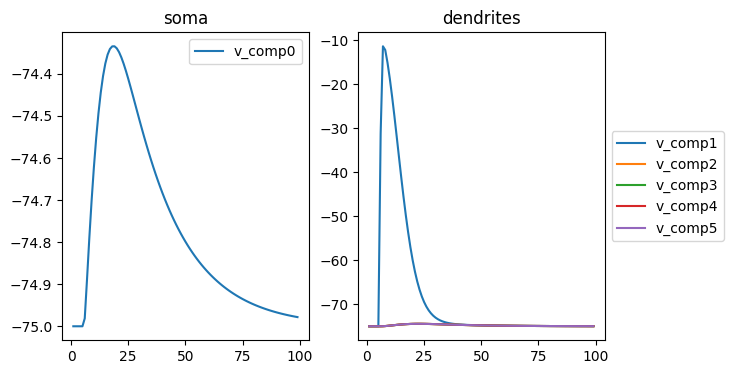

For concentrated input, we obtain a somatic depolarization of 0.66618 mV, much less than the linear sum of 1.56507 mV


In [14]:
nest.ResetKernel()

cm = create_neuron_w_dend_receptors(passive_soma=True)

# create and connect the spike generator
sg = nest.Create('spike_generator', 1, {'spike_times': [5.]})
for _ in range(5):
    nest.Connect(
        sg, cm, 
        syn_spec={
            'synapse_model': 'static_synapse', 
            'weight': .001, # uS
            'delay': 0.5, 
            'receptor_type': 0,
        }
    )

# create the recorder
mm = nest.Create('multimeter', 1)
mm.record_from = [
    'v_comp0', 'v_comp1', 'v_comp2', 'v_comp3', 'v_comp4', 'v_comp5'
]
nest.Connect(mm, cm)

# simulate the model
nest.Simulate(100.)
res = nest.GetStatus(mm, 'events')[0]

# plot the results
plot_dend_and_soma(res)

# compute delta_v
delta_v_conc = np.max(res['v_comp0']) - res['v_comp0'][0]
print(f"For concentrated input, we obtain a somatic depolarization of {delta_v_conc:.5f} mV, "\
      f"much less than the linear sum of {5*delta_v:.5f} mV")

We thus confirmed the result that spread out dendritic inputs sum linearly, but that concentrated dendritic inputs without active reinforcement sum sub-linearly.

## Dendritic computation 2.2) Supra-linear summation

Cortical and hippocampal neurons express NMDA-channels at their excitatory synapses. Through a voltage dependent Mg-block, these channels induce supralinear responses in the dendrites of cortical neurons. We repeat the previous simulations, but use a the AMPA+NMDA receptor type.

First, we simulate a single input.


**TODO:** To calculate the PSP amplitude of a single input to an AMPA+NMDA synapse, connect a spike generator to a single AMPA+NMDA receptors then simulate the model and calculate the somatic depolarization.

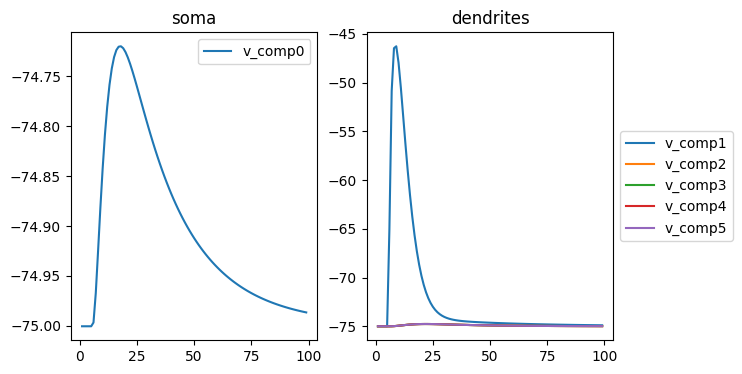

For a single input to an AMPA+NMDA synapse, we obtain a PSP amplitude of 0.28044 mV


In [15]:
AMPA_NMDA_receptor_params = {"NMDA_ratio": 2., "tau_r_NMDA": 10.}

nest.ResetKernel()

cm = create_neuron_w_dend_receptors(passive_soma=True, AMPA_NMDA_params=AMPA_NMDA_receptor_params)

# create and connect the spike generator
sg = nest.Create('spike_generator', 1, {'spike_times': [5.]})
nest.Connect(
    sg, cm, 
    syn_spec={
        'synapse_model': 'static_synapse', 
        'weight': .0008, # uS
        'delay': 0.5, 
        'receptor_type': 5, # connect to the AMPA_NMDA synapse in compartment 1
    }
)

# create the recorder
mm = nest.Create('multimeter', 1)
mm.record_from = [
    'v_comp0', 'v_comp1', 'v_comp2', 'v_comp3', 'v_comp4', 'v_comp5'
]
nest.Connect(mm, cm)

# simulate the model
nest.Simulate(100.)
res = nest.GetStatus(mm, 'events')[0]

# plot the results
plot_dend_and_soma(res)

# compute delta_v
delta_v_nmda = np.max(res['v_comp0']) - res['v_comp0'][0]
print(f"For a single input to an AMPA+NMDA synapse, we obtain a PSP amplitude of {delta_v_nmda:.5f} mV")

$\ \$
### 2.2.1) Distributed input

**TODO:** To model this distributed input scenario, connect a spike generator to all AMPA+NMDA receptors then simulate the model and calculate the somatic depolarization.

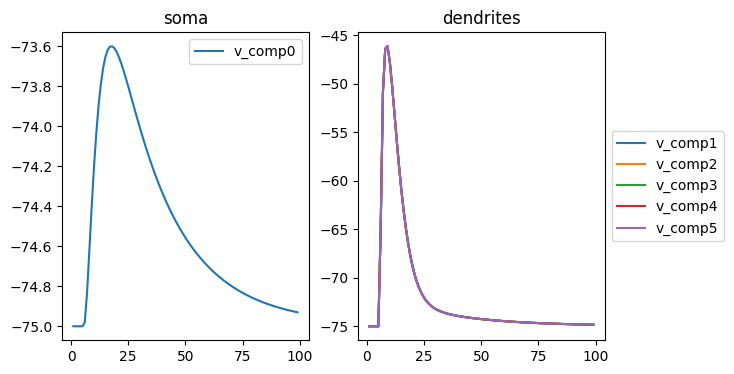

For distributed input, we obtain a somatic depolarization of 1.40102 mV, very close to the linear sum of 1.40218 mV


In [16]:
nest.ResetKernel()

cm = create_neuron_w_dend_receptors(passive_soma=True, AMPA_NMDA_params=AMPA_NMDA_receptor_params)

# create and connect the spike generator
sg = nest.Create('spike_generator', 1, {'spike_times': [5.]})
for receptor_idx in range(5,10):
    nest.Connect(
        sg, cm, 
        syn_spec={
            'synapse_model': 'static_synapse', 
            'weight': .0008, # uS
            'delay': 0.5, 
            'receptor_type': receptor_idx,
        }
    )

# create the recorder
mm = nest.Create('multimeter', 1)
mm.record_from = [
    'v_comp0', 'v_comp1', 'v_comp2', 'v_comp3', 'v_comp4', 'v_comp5'
]
nest.Connect(mm, cm)

# simulate the model
nest.Simulate(100.)
res = nest.GetStatus(mm, 'events')[0]

# plot the results
plot_dend_and_soma(res)

# compute delta_v
delta_v_nmda_distr = np.max(res['v_comp0']) - res['v_comp0'][0]
print(f"For distributed input, we obtain a somatic depolarization of {delta_v_nmda_distr:.5f} mV, "\
      f"very close to the linear sum of {5*delta_v_nmda:.5f} mV")

#### 2.2.2) Targeted single branch input
On the other hand, five spikes might target a single branch. 

**TODO:** To model this targeted input scenario, connect a spike generator five times to a single AMPA+NMDA receptor then simulate the model and calculate the somatic depolarization.

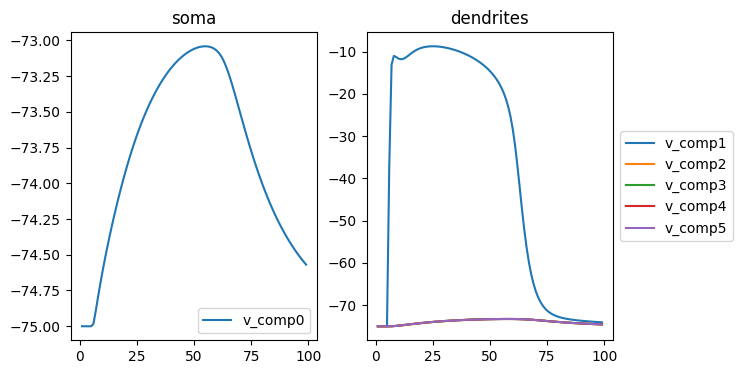

For distributed input, we obtain a somatic depolarization of 1.95959 mV, much larger than the linear sum of 1.40218 mV


In [17]:
nest.ResetKernel()

cm = create_neuron_w_dend_receptors(passive_soma=True, AMPA_NMDA_params=AMPA_NMDA_receptor_params)

# create and connect the spike generator
sg = nest.Create('spike_generator', 1, {'spike_times': [5.]})
for _ in range(5,10):
    nest.Connect(
        sg, cm, 
        syn_spec={
            'synapse_model': 'static_synapse', 
            'weight': .0008, # uS
            'delay': 0.5, 
            'receptor_type': 5,
        }
    )

# create the recorder
mm = nest.Create('multimeter', 1)
mm.record_from = [
    'v_comp0', 'v_comp1', 'v_comp2', 'v_comp3', 'v_comp4', 'v_comp5'
]
nest.Connect(mm, cm)

# simulate the model
nest.Simulate(100.)
res = nest.GetStatus(mm, 'events')[0]

# plot the results
plot_dend_and_soma(res)

# compute delta_v
delta_v_nmda_conc = np.max(res['v_comp0']) - res['v_comp0'][0]
print(f"For distributed input, we obtain a somatic depolarization of {delta_v_nmda_conc:.5f} mV, "\
      f"much larger than the linear sum of {5*delta_v_nmda:.5f} mV")

Thus, we have confirmed the result that inputs to the branches of cortical layer 5 pyramidal cells can sum supra-linearly, through activation of the NMDA receptor.

## 2.3) Output spiking

Finally, let us see if we can estimate the number of distal basal branches that need to generate coincident NMDA spikes in order to generate an output spike. To do so, we implement a routine to create a compartmental model with a configurable number of dendritic subunits.

In [18]:
def create_neuron_w_n_dends(n, AMPA_NMDA_params={}):
    compartments_list = \
        [{"parent_idx": -1, "params": soma_params}] + \
        [{"parent_idx":  0, "params": dend_params} for _ in range(n)]
    
    # define the model with its compartments
    cm = nest.Create('cm_default')
    cm.compartments = compartments_list
    # add the dendritic receptors
    cm.receptors = [
        # AMPA+NMDA receptors to all dendritic compartments
        {"comp_idx": ii, "receptor_type": "AMPA_NMDA", "params": AMPA_NMDA_params} \
        for ii in range(1,n+1)
    ]
    
    return cm

Next, we create a while loop to increase the number of branches until an output spike is generated. To each branch, we connect a spike generator that transmits 5 inputs, to generate local dendritic spikes. We connect a spike recorder to record the output spikes at the soma. 

Since this is the first example with active ion channels with non-zero conductance, we also illustrate how to record their state variables. Note that these state variables could in principle also be recorded for the passive model, but their state will not change during the simulation.

In [19]:
n_out_spikes = 0
n_dend = 5

while n_out_spikes < 1:
    n_dend += 1
    nest.ResetKernel()
    
    # create the neuron model
    cm = create_neuron_w_n_dends(n_dend, AMPA_NMDA_params=AMPA_NMDA_receptor_params)

    # create and connect the spike generator
    sg = nest.Create('spike_generator', 1, {'spike_times': [4.6,4.8,5.,5.2,5.4]})
    for receptor_idx in range(n_dend):
        nest.Connect(
            sg, cm, 
            syn_spec={
                'synapse_model': 'static_synapse', 
                'weight': .0008 * (.8 + .4 * np.random.rand()), # uS, add some randomness to the weights
                'delay': 0.5, 
                'receptor_type': receptor_idx,
            }
        )
    
    # create a spike recorder
    sr = nest.Create('spike_recorder')
    nest.Connect(cm, sr)

    # create the recorder, note that now we added the 
    # state variables of the somatic ion channels to
    # the `record_from` field of the multimeter.
    mm = nest.Create('multimeter', 1)
    mm.record_from = \
        [f'v_comp{ii}' for ii in range(n_dend+1)] + \
        ['m_Na_0', 'h_Na_0', 'n_K_0'] 
    nest.Connect(mm, cm)

    # simulate the model
    nest.Simulate(100.)
    res = mm.events
    
    # to assess whether an output spike was generated,
    # we probe the event count of the spike recorder
    n_out_spikes = sr.n_events
    
print(f"The Layer 5 pyramidal cell model produced an output spike when " \
      f"{n_dend} dendritic compartments where present and activated")

The Layer 5 pyramidal cell model produced an output spike when 6 dendritic compartments where present and activated


Finally, we plot all recordings.

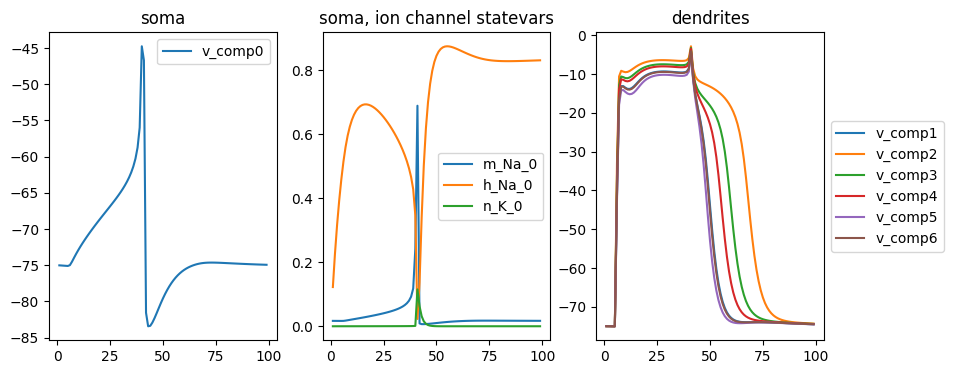

In [20]:
plt.figure(figsize=(10,4))

ax1 = plt.subplot(131)
ax1.set_title("soma")
plt.plot(res['times'], res['v_comp0'], label='v_comp0')
plt.legend(loc=0)

ax1 = plt.subplot(132)
ax1.set_title("soma, ion channel statevars")
plt.plot(res['times'], res['m_Na_0'], label='m_Na_0')
plt.plot(res['times'], res['h_Na_0'], label='h_Na_0')
plt.plot(res['times'], res['n_K_0'], label='n_K_0')
plt.legend(loc=0)

ax2 = plt.subplot(133)
ax2.set_title("dendrites")
plt.plot(res['times'], res['v_comp1'], label='v_comp1')
plt.plot(res['times'], res['v_comp2'], label='v_comp2')
plt.plot(res['times'], res['v_comp3'], label='v_comp3')
plt.plot(res['times'], res['v_comp4'], label='v_comp4')
plt.plot(res['times'], res['v_comp5'], label='v_comp5')
plt.plot(res['times'], res['v_comp6'], label='v_comp6')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

$\ \$

Compartmental models in NEST: 3) Networks of compartmental neurons 
==========================

In this section we will adapt the model of 

`Brunel (2000) Dynamics of sparsely connected networks of excitatory and inhibitory spiking neurons. Journal of Computational Neuroscience 8(3):183-208`

to a simple network of compartmental neurons with AMPA, GABA, and NMDA receptors. For the compartments we will use the parameters defined above which are extracted using NEAT, to represent a Layer 5 Pyramidal cell's soma, and a distal dendritic compartment on the basal dendrites. We will investigate the implications on dynamics with a special focus on the NMDA-receptors.

## 3.1) Creating populations

To start investigating compartmental neurons on a network level we need to create multiple neurons to build a population. To do so we first rewrite our functions that create a compartmental neuron to  one which creates populations of compartmental neurons. 

For a balanced network we need both excitatory and inhibitory neurons. In the previous examples we used a simplified model of a pyramidal neuron which is a suitable candidate for an excitatory neuron. 
To keep this example as simple as possible, we will create a very simple neuron for the inhibitory population. For this we can use the `soma_params` to create a neuron model only consisting of a somatic compartment. By adding both `AMPA` and `GABA` receptors we can reproduce the most basic features of an inhibitory neuron. 
To model input we will use Poisson generators. In order to connect those we will also add an `AMPA` receptor to the somatic compartment of the excitatory neuron. To enable connections between the excitatory and inhibitory population, we now also add `GABA` receptors to the dendritic as well as the somatic compartments of our excitatory neuron. 

**TODO:** Complete the function that creates the inhibitory population as it is described above. (Add the AMPA receptor before the GABA receptor)

In [21]:
def create_excitatory_population(n_neurons, passive_soma=False, AMPA_params={}, GABA_params={}, AMPA_NMDA_params={}):
    
    if passive_soma:
        soma_params_ = soma_params_pas
    else:
        soma_params_ = soma_params
    
    # create pupulation of n_neurons compartmental neurons 
    cm_population = nest.Create('cm_default', n_neurons)
    # define their compartments
    cm_population.compartments = [
        {"parent_idx": -1, "params": soma_params_},
        {"parent_idx":  0, "params": dend_params},
        {"parent_idx":  0, "params": dend_params},
        {"parent_idx":  0, "params": dend_params},
        {"parent_idx":  0, "params": dend_params},
        {"parent_idx":  0, "params": dend_params},
    ]
    # add the dendritic receptors
    cm_population.receptors = [
        # AMPA receptors to the somatic compartment
        {"comp_idx": 0, "receptor_type": "AMPA", "params": AMPA_params},
        # GABA receptors to the somatic compartment
        {"comp_idx": 0, "receptor_type": "GABA", "params": GABA_params},
        # GABA receptors to all dendritic compartments
        {"comp_idx": 1, "receptor_type": "GABA", "params": GABA_params},
        {"comp_idx": 2, "receptor_type": "GABA", "params": GABA_params},
        {"comp_idx": 3, "receptor_type": "GABA", "params": GABA_params},
        {"comp_idx": 4, "receptor_type": "GABA", "params": GABA_params},
        {"comp_idx": 5, "receptor_type": "GABA", "params": GABA_params},
        # AMPA+NMDA receptors to all dendritic compartments
        {"comp_idx": 1, "receptor_type": "AMPA_NMDA", "params": AMPA_NMDA_params},
        {"comp_idx": 2, "receptor_type": "AMPA_NMDA", "params": AMPA_NMDA_params},
        {"comp_idx": 3, "receptor_type": "AMPA_NMDA", "params": AMPA_NMDA_params},
        {"comp_idx": 4, "receptor_type": "AMPA_NMDA", "params": AMPA_NMDA_params},
        {"comp_idx": 5, "receptor_type": "AMPA_NMDA", "params": AMPA_NMDA_params},
    ]
    
    return cm_population 

def create_inhibitory_population(n_neurons, passive_soma=False, AMPA_params={}, GABA_params={}):
    if passive_soma:
        soma_params_ = soma_params_pas
    else:
        soma_params_ = soma_params
    
    # define the model with its compartment
    cm_population = nest.Create('cm_default', n_neurons)
    cm_population.compartments = [
        {"parent_idx": -1, "params": soma_params_},
    ]
    # add the dendritic receptors
    cm_population.receptors = [
        # AMPA receptors to somatic compartment
        {"comp_idx": 0, "receptor_type": "AMPA", "params": AMPA_params},
        # GABA receptors to somatic compartment
        {"comp_idx": 0, "receptor_type": "GABA", "params": GABA_params},
    ]
    
    return cm_population 

## 3.2) Building a network of compartmental neurons 

Now that we can create population of excitatory and inhibitory neurons, we need to connect them. For a Brunel-network we recurrently connect the two sub-populations with a connection density of `0.1`. Furthermore we will create Poisson generators to drive the network. 

By connecting multimeters to multiple of our excitatory neurons we can monitor their state and see if the network operates in a dynamical regime where we surpass the magnesium block in some of the dendritic compartments. As in 2.2.2) successful unblocking and thus NMDA-receptor activation will lead to voltage traces which remain above -35mV for at least 30ms. In most cases this should be visible by looking at the voltage traces of the dendritic compartments of some of the excitatory neurons. Below you can see dendritic voltage traces with clearly visible NMDA-receptor activation (purple and orange) as well as their corresponding somatic voltage trace.

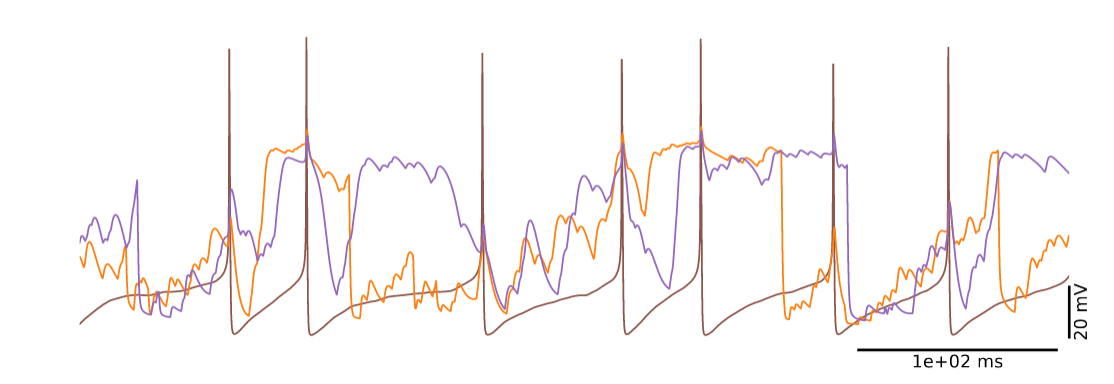

We also connect Poisson generators to the `AMPA` receptors at the somatic compartments of our two recurrently connected sub-populations to drive the network. 

Note that, initially all membrane potentials are at the resting potential which is why we need to run the network for $500-1000$ms to initialize the network. This initialization can often lead to a ramp up of activity in both population before eventually stabilizing. It is important that we mainly focus on the activity after $1000$ms if we want to classify in which dynamical regime our network is in.

We will once again wrap the creation, simulation, and plotting of the network into a function such that we can easily run the network for different parameters.

**TODO:** Fill in the missing gaps in the `build_network` function


In [22]:
def build_network(inhibition = 'RAND_DEND', g=16, input_rate =14.0, sim_time = 1500., N_rec = 200, w_exc=0.00025):
    """
    Quickly build, run, and plot spike data 
    and dendritic voltage traces of a 
    "Brunel type" network of compartmental 
    neurons.
    
    Arguments:
        inhibition: SOMA or RAND_DEND 
                        each inhibitory connection
                        to either the GABA receptor 
                        of a random dendritic or 
                        the somatic compartment
        g         : g*w_exc is the weight of the 
                    inhibitory connections
        input_rate: rate of the poisson input
        sim_time  : simulation time in ms
        N_rec     : number of neurons  to record
                    of each population for the 
                    raster plot
        w_exc     : weight of the excitatory 
                    connections
                    
    """
    # Reset nest 
    nest.ResetKernel()

    # creating the populations
    exc_pop = create_excitatory_population(1000)
    inh_pop = create_inhibitory_population(250)

    # connecting the two subpopulations 
    # fixed indegrees (Brunel network) with a density of 0.1
    K_EE = int(0.1 * len(exc_pop))
    K_EI = int(0.1 * len(exc_pop))
    K_IE = int(0.1 * len(inh_pop))
    K_II = int(0.1 * len(inh_pop))
    # setting connection parameters
    conn_params_EE = {'rule': 'fixed_indegree', 'indegree': K_EE,
        'allow_autapses': False, 'allow_multapses': False}
    conn_params_EI = {'rule': 'fixed_indegree', 'indegree': K_EI,
        'allow_autapses': False, 'allow_multapses': False}
    conn_params_IE = {'rule': 'fixed_indegree', 'indegree': K_IE,
        'allow_autapses': False, 'allow_multapses': False}
    conn_params_II = {'rule': 'fixed_indegree', 'indegree': K_II,
         'allow_autapses': False, 'allow_multapses': False}
    
    # inhibition to the somatic compatments of the exc neurons
    if inhibition == 'SOMA':
        rec_ids_IE = 1 
    # inhibition to a random dendritic compatments of the exc neurons
    # [1,2,3,4,5] are the GABA receptors of our excitatory neuron 
    elif inhibition == 'RAND_DEND':
        rec_ids_IE = np.random.choice([2,3,4,5,6], (len(exc_pop), K_IE)) 
    else:
        ValueError('type of inhibition not supoorted \n only: RAND_DEND or SOMA')

    # connect the excitatory connections to a random dendritic compartment
    # [6,7,8,9,10] are the AMPA_NMDA receptors of our excitatory neuron 
    rec_ids_EE = np.random.choice([7,8,9,10,11], (len(exc_pop), K_EE)) 
    # What is the excitatory receptor of the inhibitory neuron?
    rec_ids_EI = 0
    # What is the inhibitory receptor of the excitatory neuron?
    rec_ids_II = 1

    # recurrently connect the excitatory population
    nest.Connect(exc_pop, exc_pop, conn_params_EI, syn_spec = {"synapse_model" : "static_synapse", "weight":
                    w_exc, "delay": 1. , 'receptor_type': rec_ids_EE})
    # connect excitatory population to the inhibitory
    nest.Connect(exc_pop, inh_pop, conn_params_EI, syn_spec = {"synapse_model" : "static_synapse", "weight":
                    w_exc, "delay": 1. , 'receptor_type': rec_ids_EI})
    # connect inhibitory population to the excitatory 
    nest.Connect(inh_pop, exc_pop, conn_params_IE, syn_spec = {"synapse_model" : "static_synapse", "weight":
                    w_exc * g , "delay": 0.1, 'receptor_type': rec_ids_IE})
    # recurrently connect the inhibitory population
    nest.Connect(inh_pop, inh_pop, conn_params_II, syn_spec = {"synapse_model" : "static_synapse", "weight":
                    w_exc * g, "delay": 0.1 ,'receptor_type': rec_ids_II})
    
    
    # Connecting poisson input to the excitatory and inhibitory population
    # create a simple poisson generator 
    poisson_input = nest.Create('poisson_generator')
    # Setting the input rate of the poisson generator 
    # Simplification inpired by Brunel network:
    #     effective_rate = 0.1 * number_of_excitatory_neurons * input_rate 
    nest.SetStatus(poisson_input, {'rate': input_rate * 0.1 * len(exc_pop)})

    nest.Connect(
            poisson_input, exc_pop + inh_pop, 
            syn_spec={
                'synapse_model': 'static_synapse', 
                'weight': w_exc, 
                'delay': 0.5, 
                'receptor_type': 0,
            }
        )

    
    # create spike recorders
    spikes_e = nest.Create('spike_recorder')
    spikes_i = nest.Create('spike_recorder')
    # creating additional spike recorder to determine the mean rate after initialization
    spikes_rate = nest.Create('spike_recorder')
    # setting start times to ignore initialization phase 
    spikes_rate.start = 1000.
    # connecting the spike recorder to N_rec of the neurons 
    nest.Connect(exc_pop[:N_rec], spikes_e, syn_spec={'delay': 1.})
    nest.Connect(inh_pop[:N_rec], spikes_i, syn_spec={'delay': 1.})
    nest.Connect(exc_pop + inh_pop, spikes_rate, syn_spec={'delay': 1.})
    



    # choose ids of the excitatory
    record_ids = [11, 140, 280, 573, 810]
    # create a multimeters to record the voltage traces 
    mm = nest.Create('multimeter', len(record_ids))
    # setting start and stop time to only capture after initialization
    mm.start = 1000.
    mm.stop = 1200
    mm.record_from = [
        'v_comp0', 'v_comp1', 'v_comp2', 'v_comp3', 'v_comp4', 'v_comp5'
    ]
    # connecting multimeters to five of the excitatory neurons 
    for i, id in enumerate(record_ids):
        nest.Connect(mm[i], exc_pop[id])

    # running the simulation
    nest.Simulate(sim_time)
    
    # calculating the mean rate from the spike data
    events_rate = nest.GetStatus(spikes_rate, 'n_events')[0]
    mean_rate = events_rate / sim_time / N_rec * 1e3

    # raster plots for the excitatory and inhibitory population
    nest.raster_plot.from_device(spikes_i, hist=True)
    nest.raster_plot.from_device(spikes_e, hist=True)
    print('Mean firing rate: {} Hz'.format(mean_rate))

    # plotting voltage neurons defined by record_ids 
    for i in range(len(record_ids)):
        res = nest.GetStatus(mm[i], 'events')[0]
        plot_dend_and_soma(res)


## 3.3) Investigating the parameter space 

Now that we have a simple way to create a "Brunel type" network with different parameters, we can start investigating to see what impact compartmental neurons can have on the resulting network state. In this section we will vary the values of `inhibition`, as well as the `input_rate` and the relative inhibition `g` to find new interesting dynamical regimes. 

Generally we are interested in bio-plausible networks, i.e asynchronous and irregular firing patterns with a rate below 20Hz. In the following the task will be to find network states for both somatic and random dendritic inhibition which either display or do not display NMDA-receptor activation in the dendritic voltage traces. 

**Hint:** Try to keep `input_rate` $\in [10,20]$Hz as well as `g` $\in [8, 18]$.

#### 3.3.1) Dendritic inhibition without NMDA-receptor activation

**TODO:** Try o find a suitable values of `g` and `input_rate` with **no** visible activation of the NMDA-receptors in the exemplary voltage traces.

**Bonus**: Is there a combination of parameters such that both populations also display asynchronous and irregular spiking activity with an average rate of less than 20Hz?

Mean firing rate: 0.2033333333333333 Hz


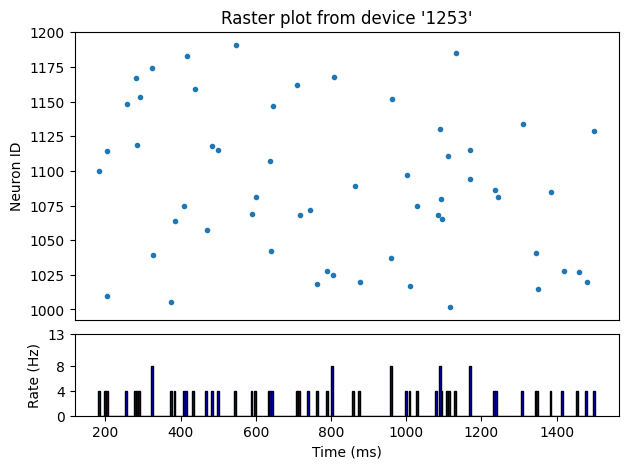

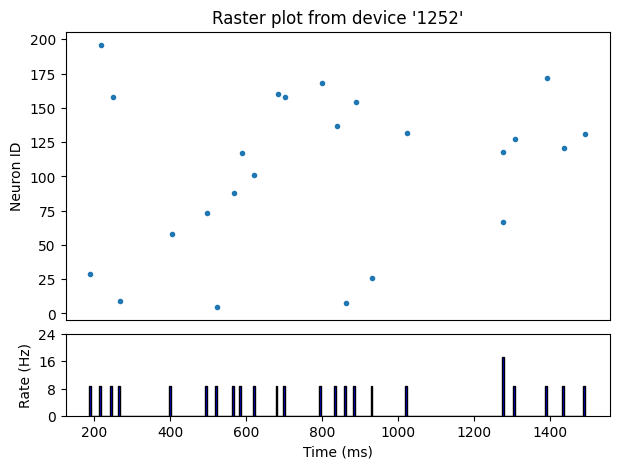

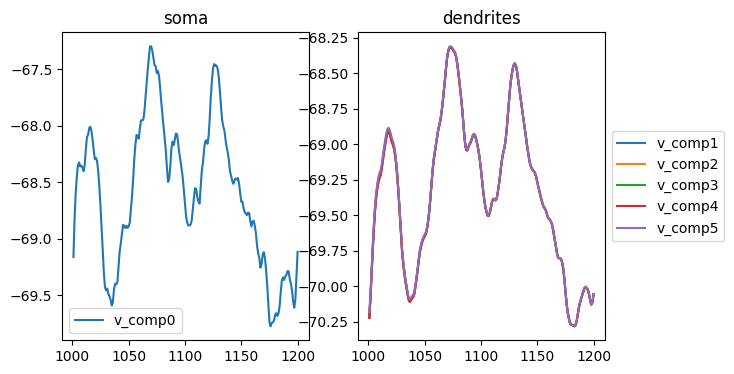

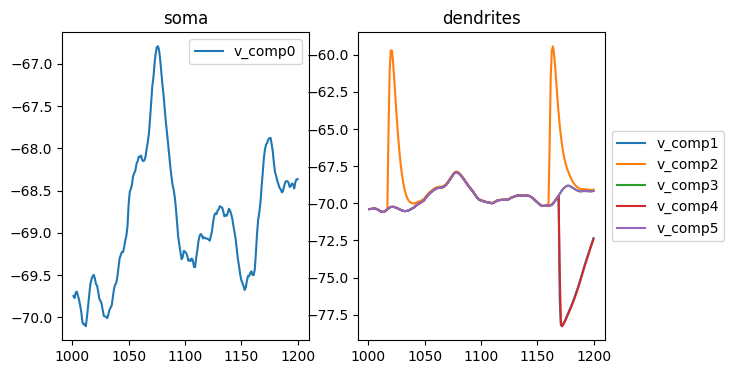

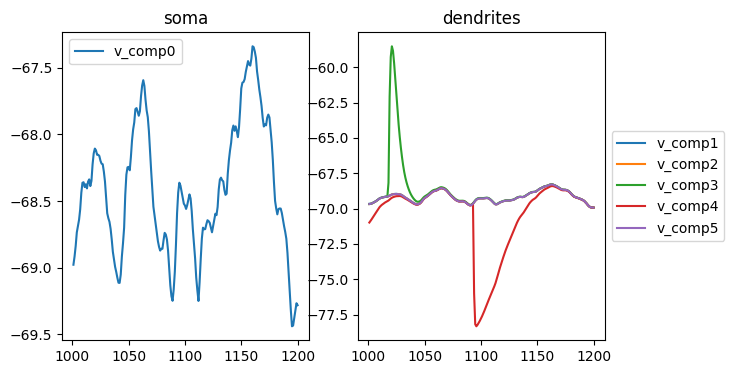

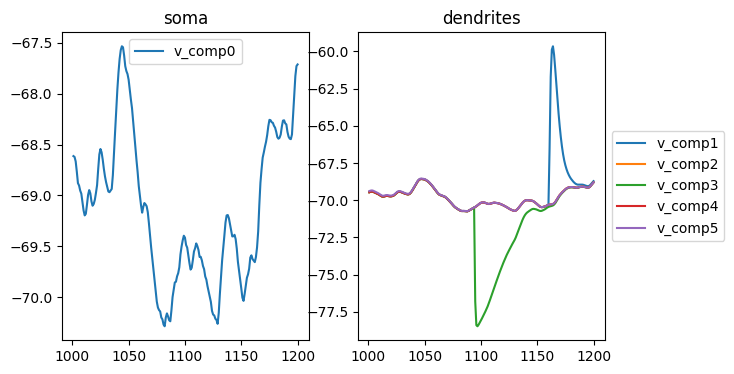

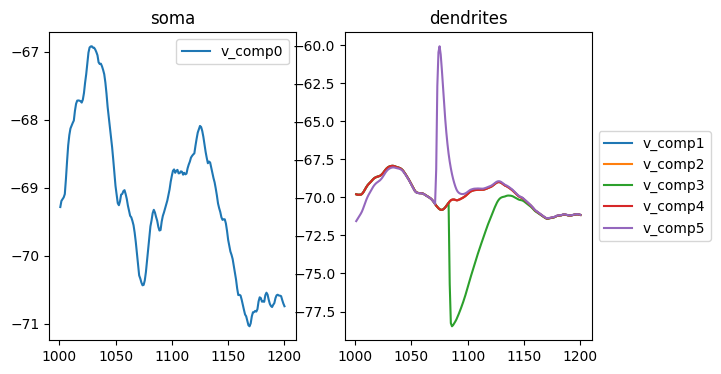

In [23]:
build_network(inhibition = 'RAND_DEND', g = 16., input_rate = 13.)

**Solution:** With `inhibition = 'RAND_DEND', g = 16., input_rate = 13.` we find that the networks operates at a very low average rate. However the raster plot indicates asynchronous and irregular spiking activity while there are no visible NMDA-receptor activity in the dendritic voltage traces. 

#### 3.3.2) Dendritic inhibition with NMDA-receptor activation


**TODO:** Try to find a suitable values of `g` and `input_rate` **with** visible activation of the NMDA-receptors in the exemplary voltage traces.

**Bonus**: Is there a combination of parameters such that both populations also display asynchronous and irregular spiking activity with an average rate of less than 20Hz?

Mean firing rate: 20.080000000000002 Hz


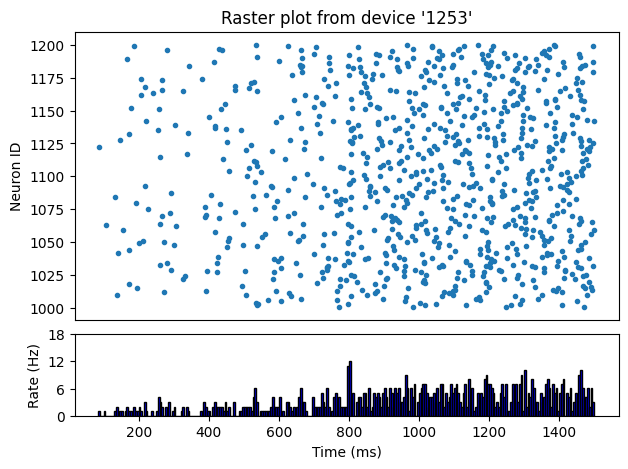

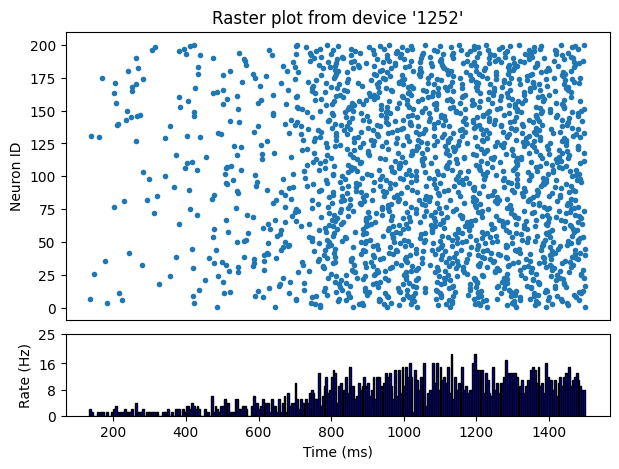

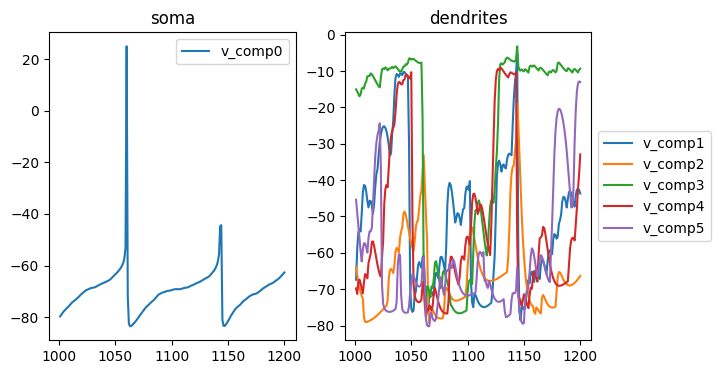

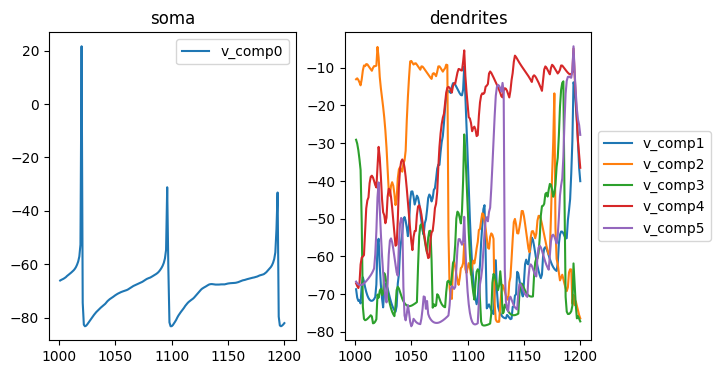

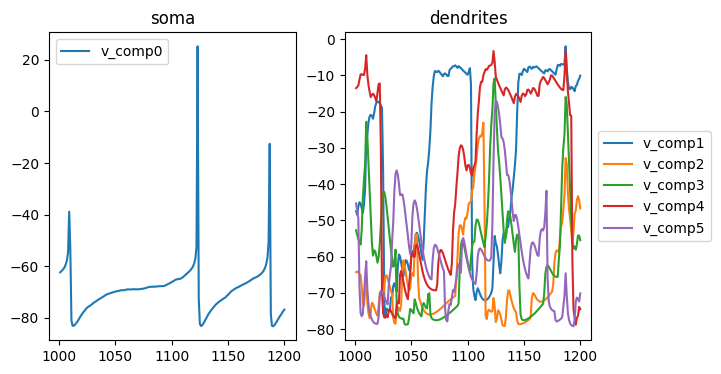

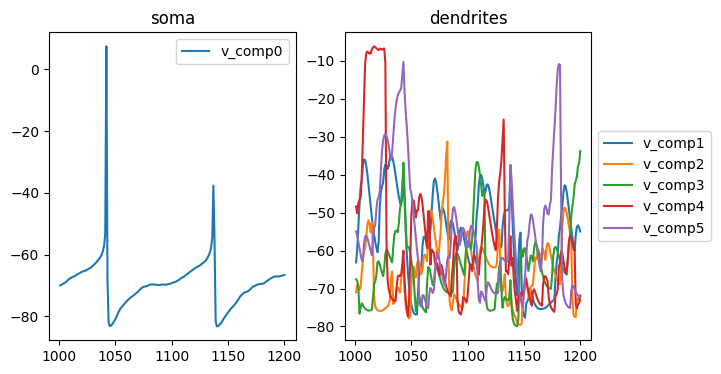

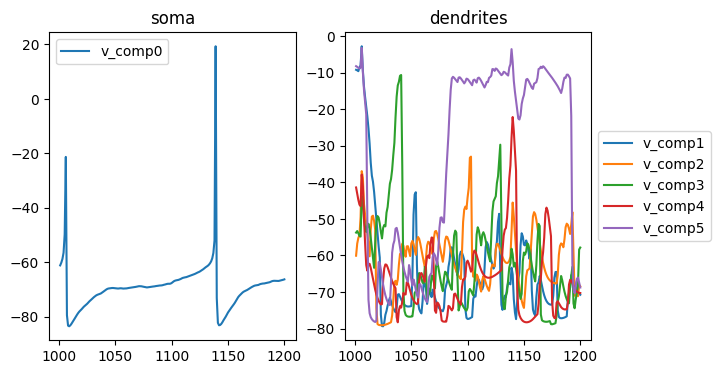

In [24]:
build_network(inhibition = 'RAND_DEND', g = 14., input_rate = 14.)

**Solution:** With `inhibition = 'RAND_DEND', g = 14., input_rate = 14.` we find that the networks operates at a firing rate of just below $20$Hz. Looking at the raster plot we see largely asynchronous and irregular spiking activity while there is clearly visible NMDA-receptor activity in the dendritic voltage traces. 

#### 3.3.3) Somatic inhibition without NMDA-receptor activation 

**TODO:** Try to find a suitable values of `g` and `input_rate` with **no** visible activation of the NMDA-receptors in the exemplary voltage traces.

**Bonus**: Is there a combination of parameters such that both populations also display asynchronous and irregular spiking activity with an average rate of less than 20Hz?


Mean firing rate: 2.02 Hz


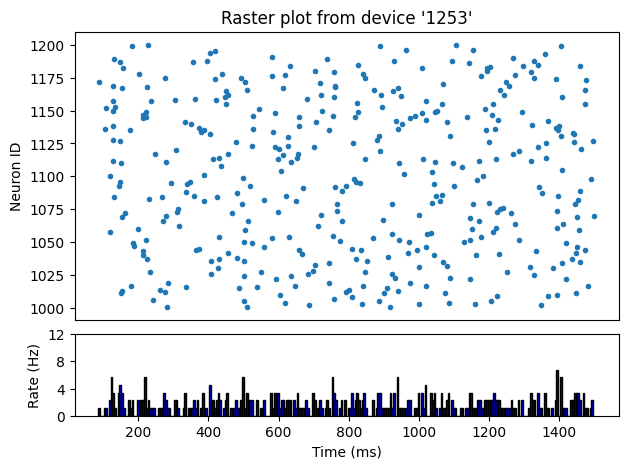

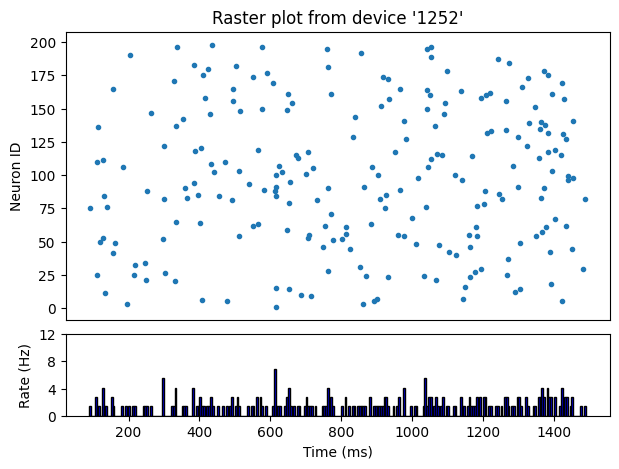

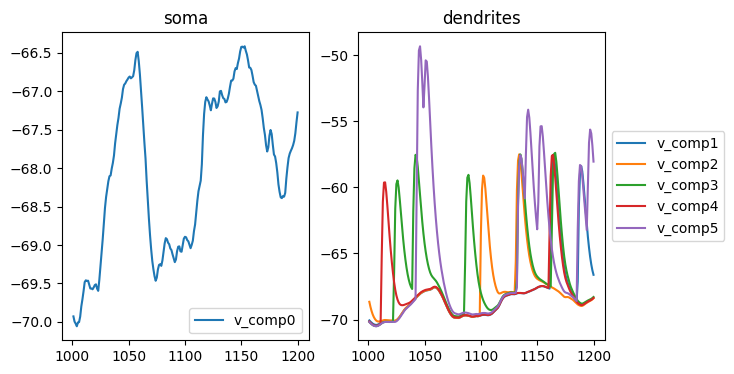

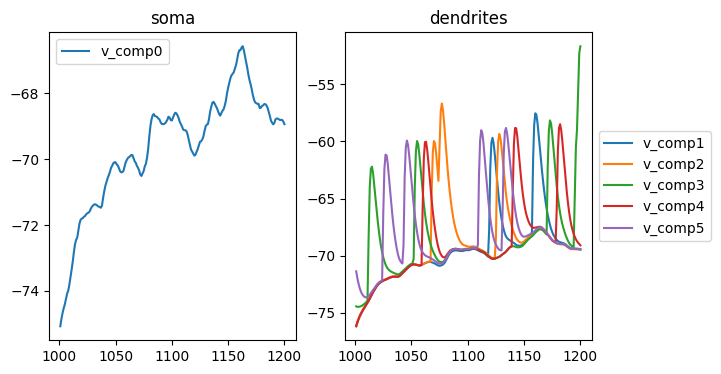

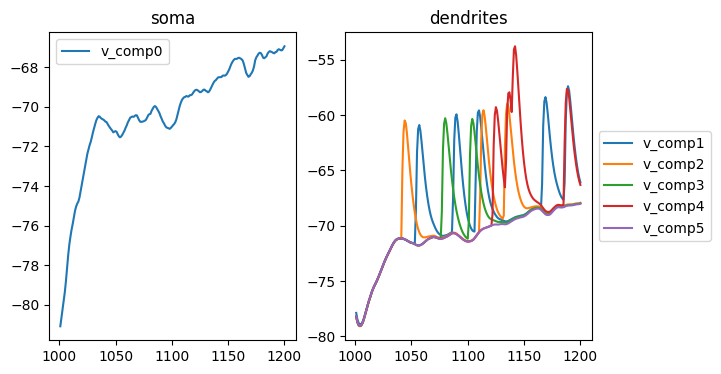

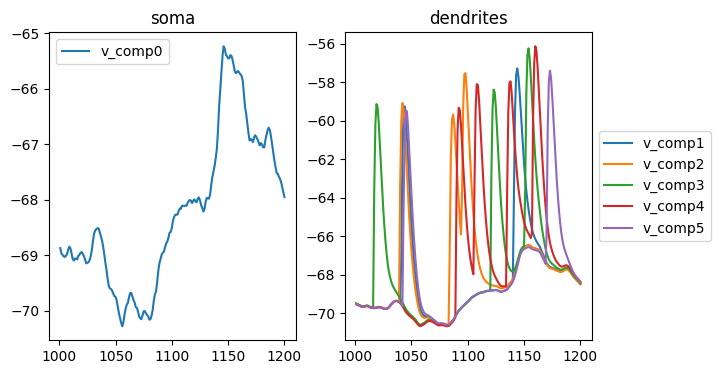

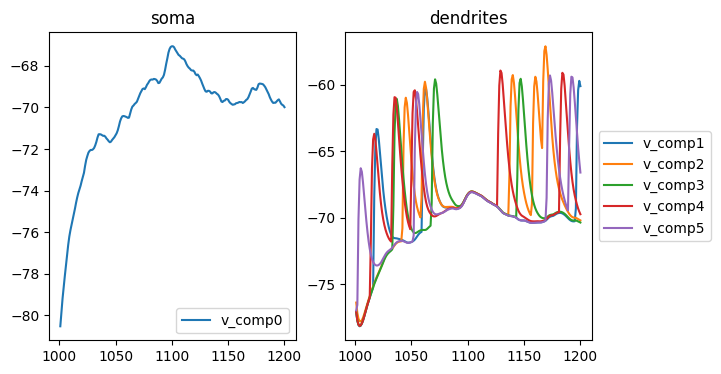

In [25]:
build_network(inhibition = 'SOMA', g = 12., input_rate = 15.)

**Solution:** With `inhibition = 'SOMA', g = 12., input_rate = 15.` we find that the networks operates at a low firing rate of just about $2$Hz. The raster plot shows perfectly asynchronous and irregular spiking activity while there is no visible NMDA-receptor activity in the dendritic voltage traces. 

#### 3.3.4) Somatic inhibition with NMDA-receptor activation 


**TODO:** Try to find a suitable values of `g` and `input_rate` **with** visible activation of the NMDA-receptors in the exemplary voltage traces.

**Bonus**: Is there a combination of parameters such that both populations also display asynchronous and irregular spiking activity with an average rate of less than 20Hz?

In [ ]:
build_network(inhibition = 'SOMA', g = 10., input_rate = 20.)

**Solution:** With `inhibition = 'SOMA', g = 10., input_rate = 20.` we find that the networks operates at a extreme firing rate of above $45$Hz. The raster plot displays synchronous and regular spiking activity once stabilized while the voltages of all dendritic compartments remain above $-30$mV constantly. For this case it is not possible to achieve asynchronous and irregular spiking activity while reliably activating the NMDA-receptors. 